<a href="https://colab.research.google.com/github/281096alif/-my-first-repo/blob/main/10_02_25_dip_project_bengalDeltaFish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Feb 10 13:26:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [4]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.2/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata

from roboflow import Roboflow
rf = Roboflow(api_key="ZJ5NnQfVOmGzbTwjF7gj")
project = rf.workspace("dipfishdataset").project("bd-delta-fish")
version = project.version(4)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to -bd-delta-fish--4 in yolov11:: 100%|██████████| 10184/10184 [00:01<00:00, 5456.64it/s]


## Custom Training

In [6]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=50 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 97.2MB/s]
New https://pypi.org/project/ultralytics/8.3.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/-bd-delta-fish--4/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [7]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1739194314.6b46488de6b4.1938.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	 val_batch2_pred.jpg
labels.jpg					    train_batch8920.jpg  weights
P_curve.png					    train_batch8921.jpg
PR_curve.png					    train_batch8922.jpg


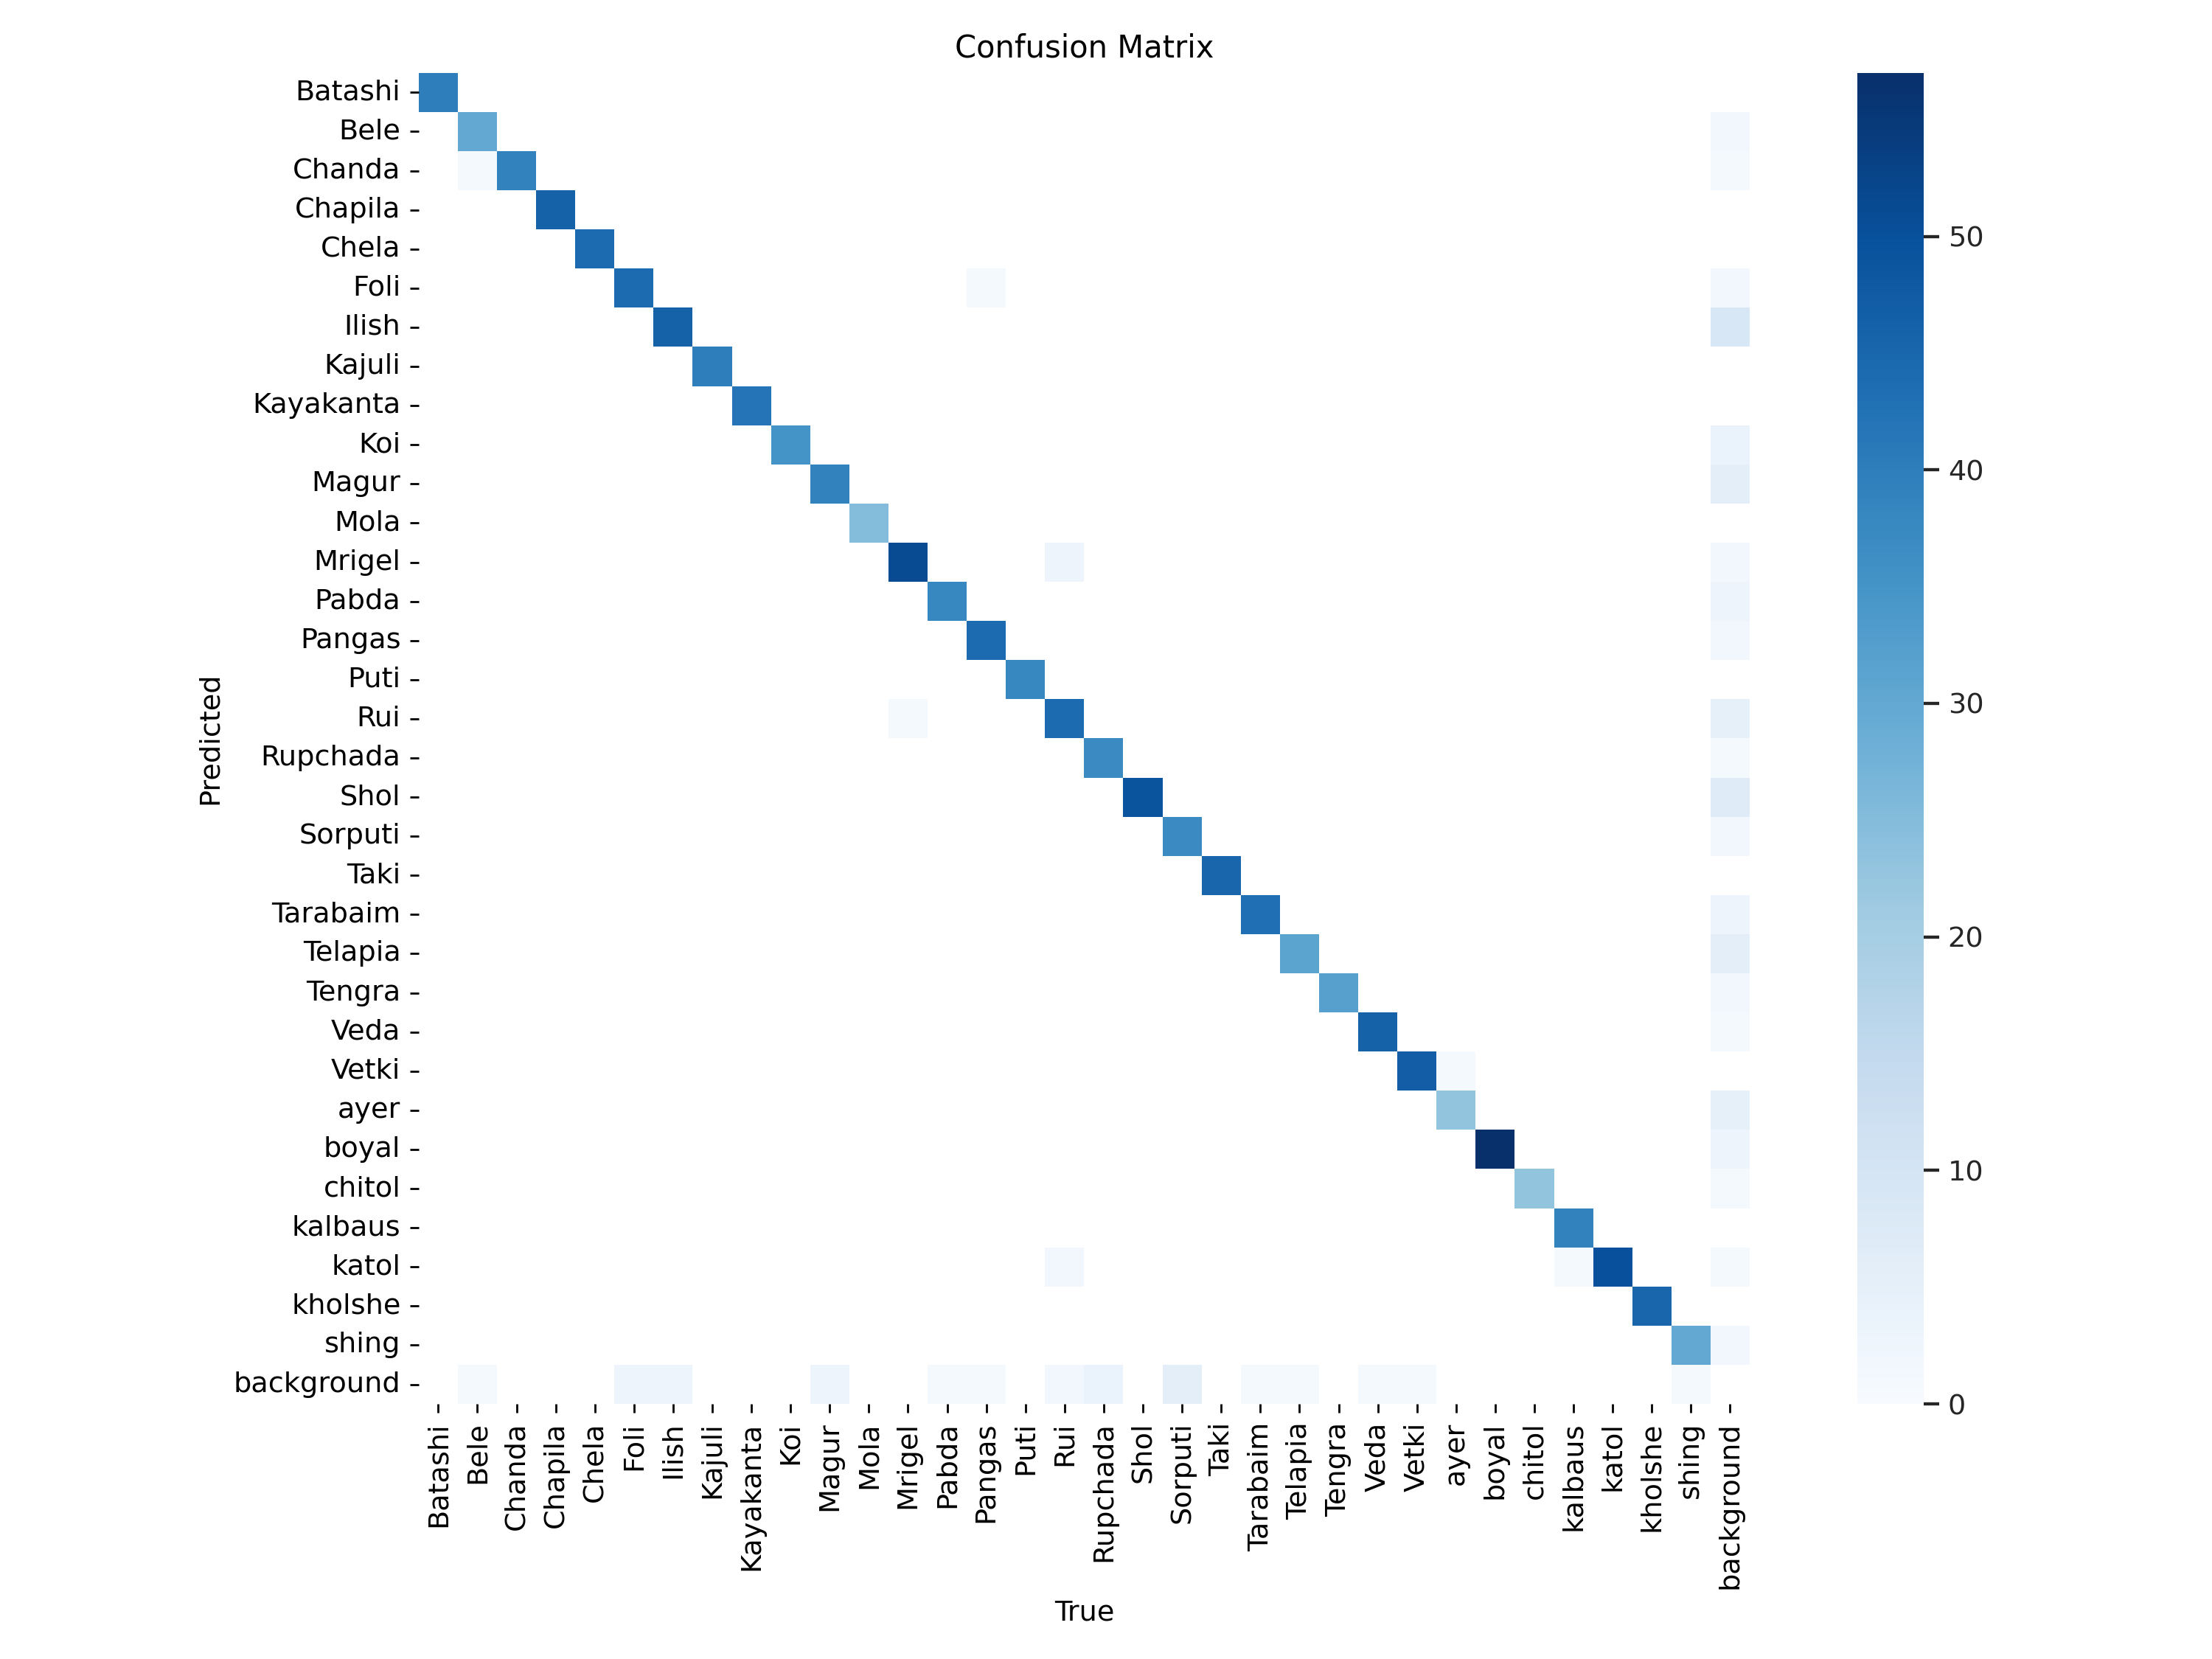

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

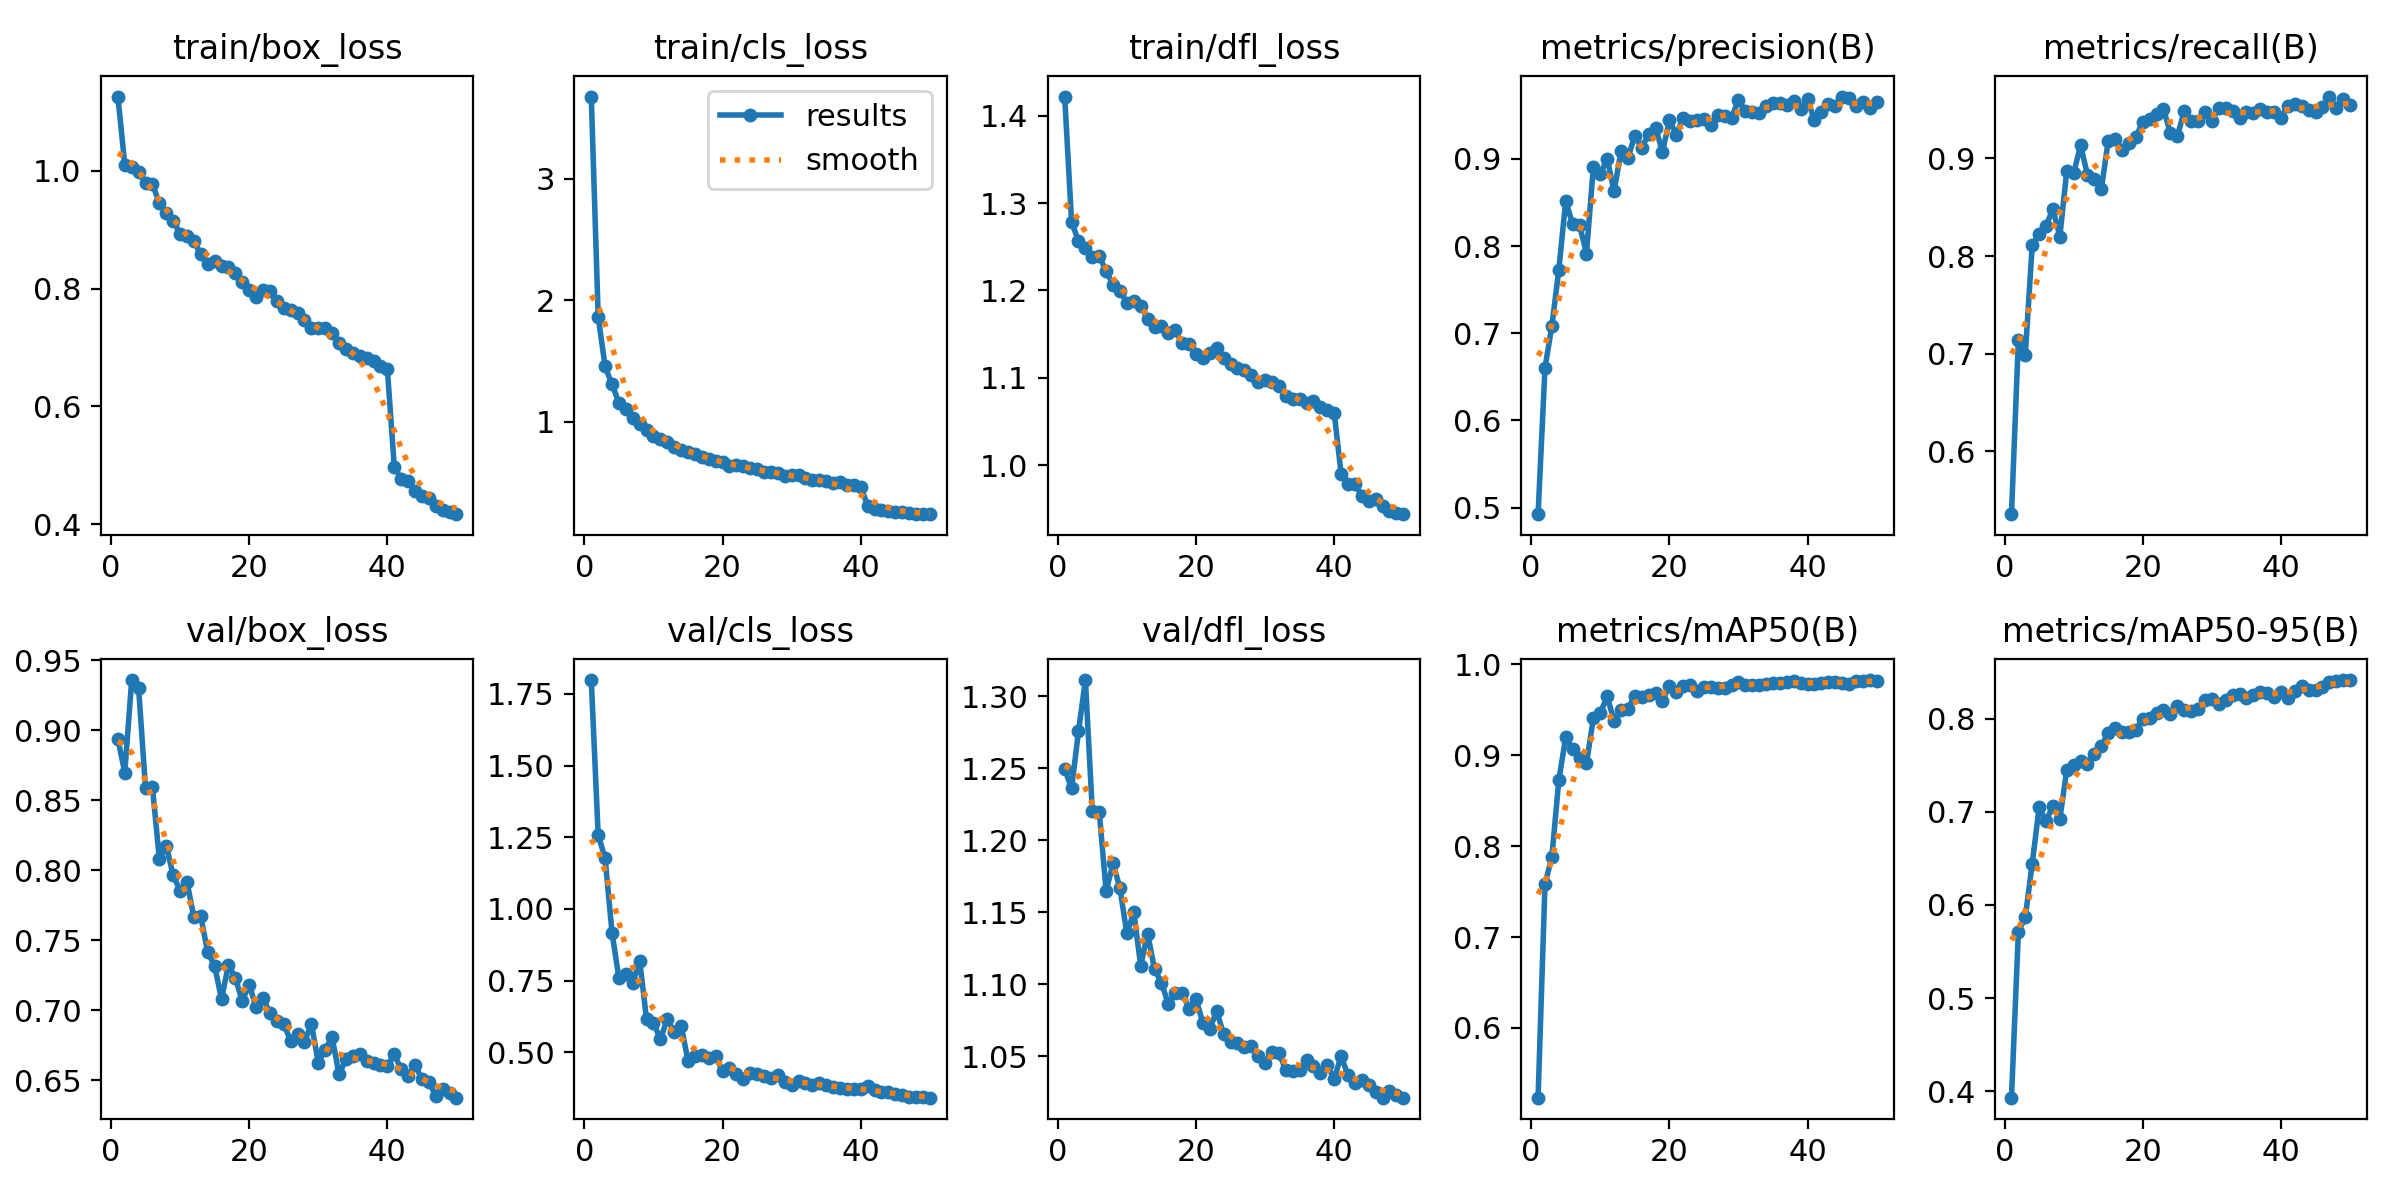

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

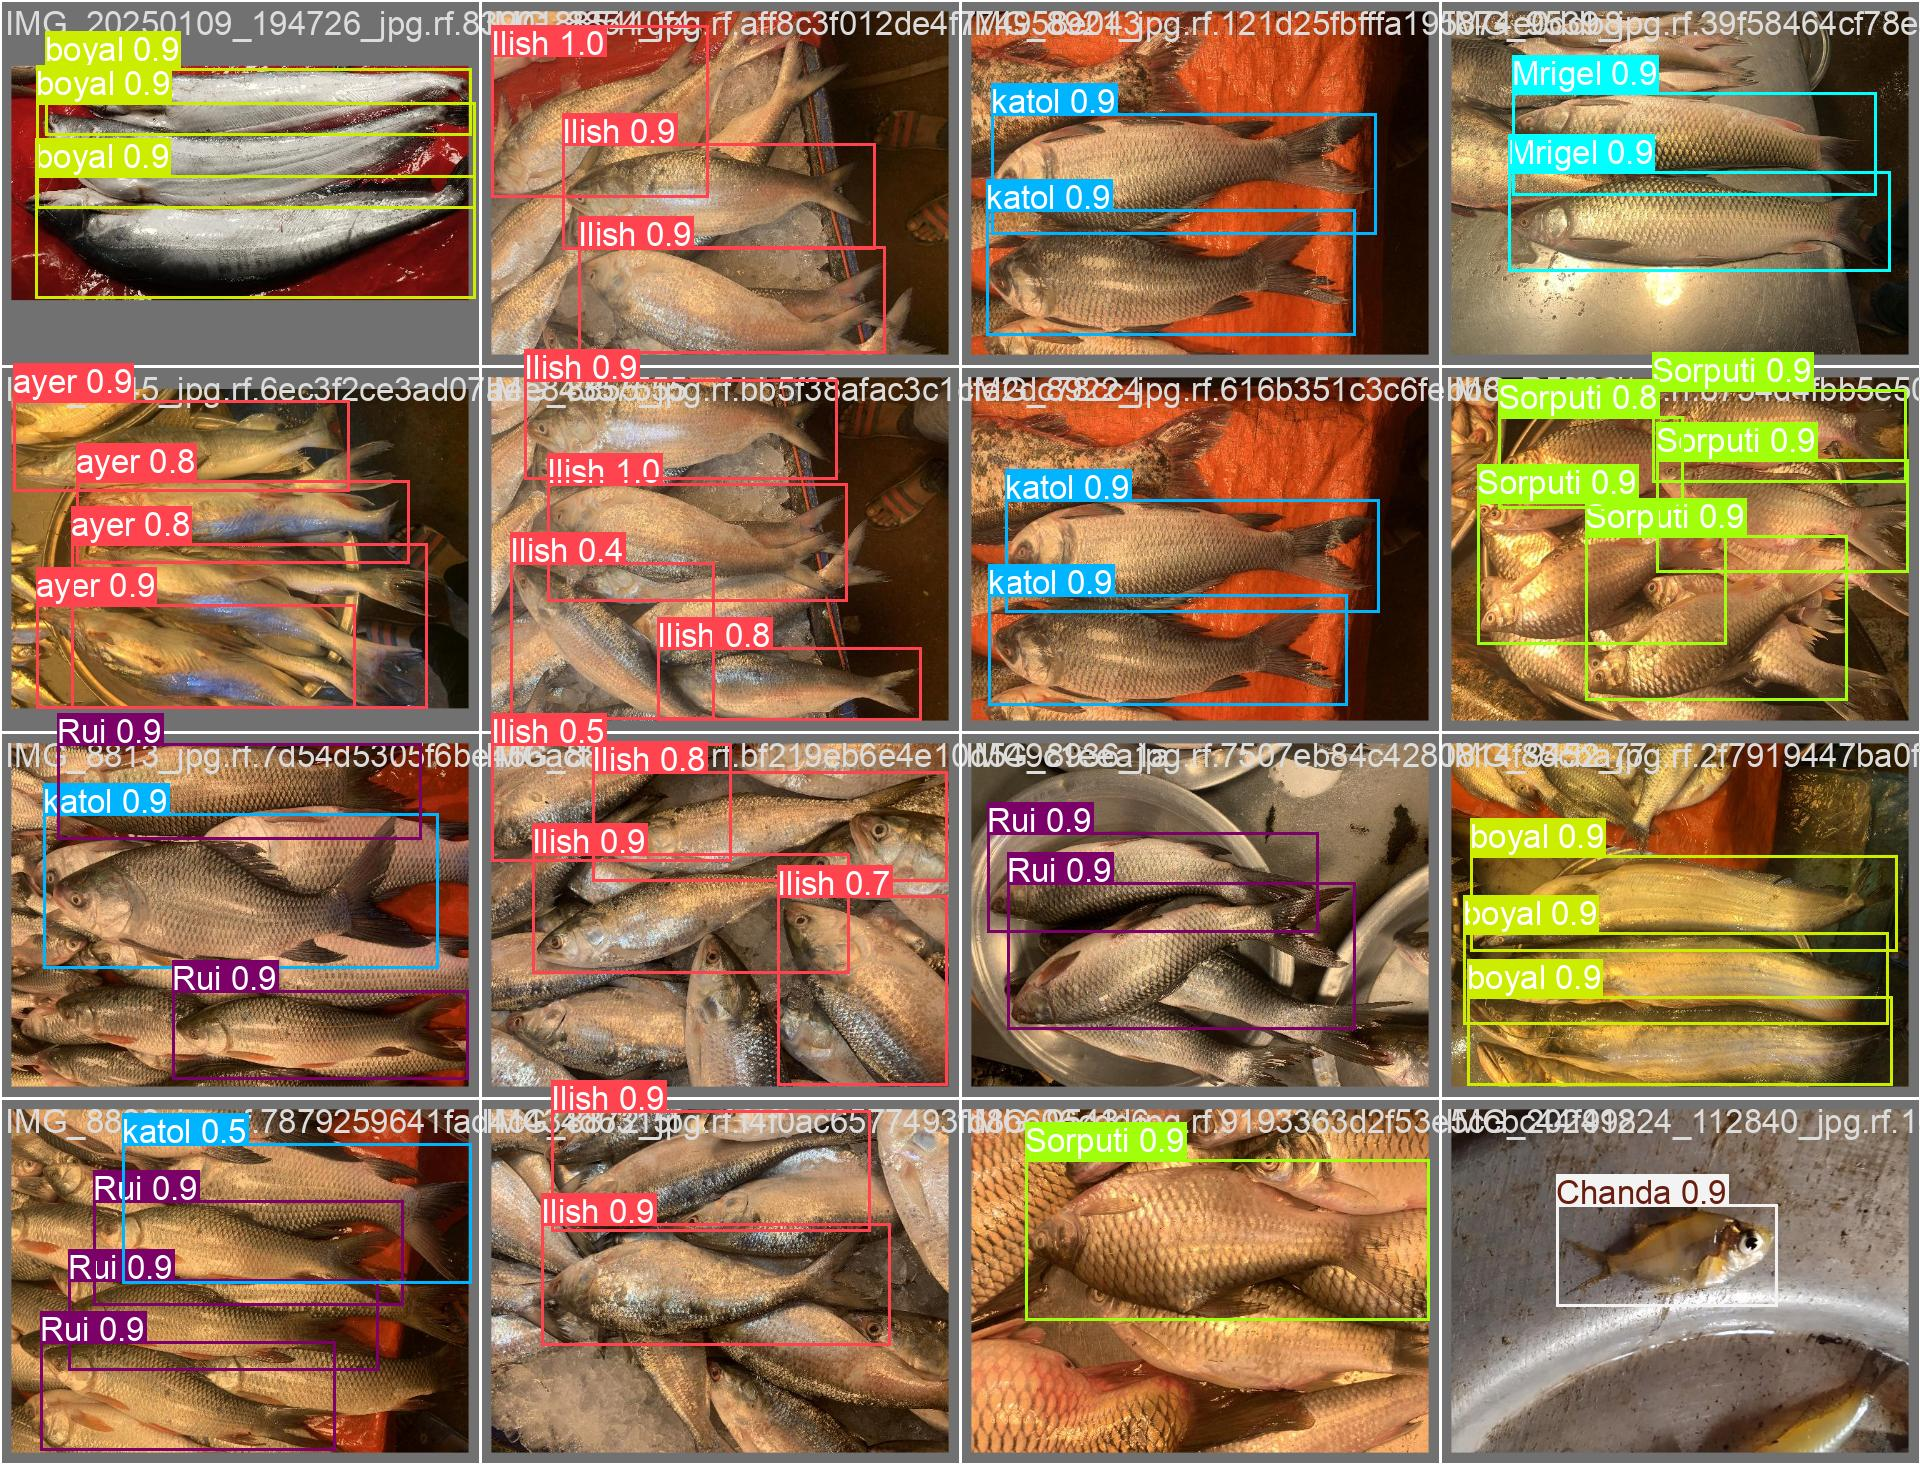

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [11]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,425,571 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/datasets/-bd-delta-fish--4/valid/labels.cache... 1009 images, 0 backgrounds, 0 corrupt: 100% 1009/1009 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 64/64 [00:12<00:00,  5.13it/s]
                   all       1009       1358      0.959       0.96      0.983      0.841
               Batashi         40         40      0.988          1      0.995      0.862
                  Bele         28         32      0.936      0.908       0.96      0.766
                Chanda         39         39      0.946          1      0.995      0.881
               Chapila         41         46          1      0.989      0.995      0.883
                 Chela         44         44      0.988          1      0.995      0.789
                  Foli         

Validation Confusion Matrix

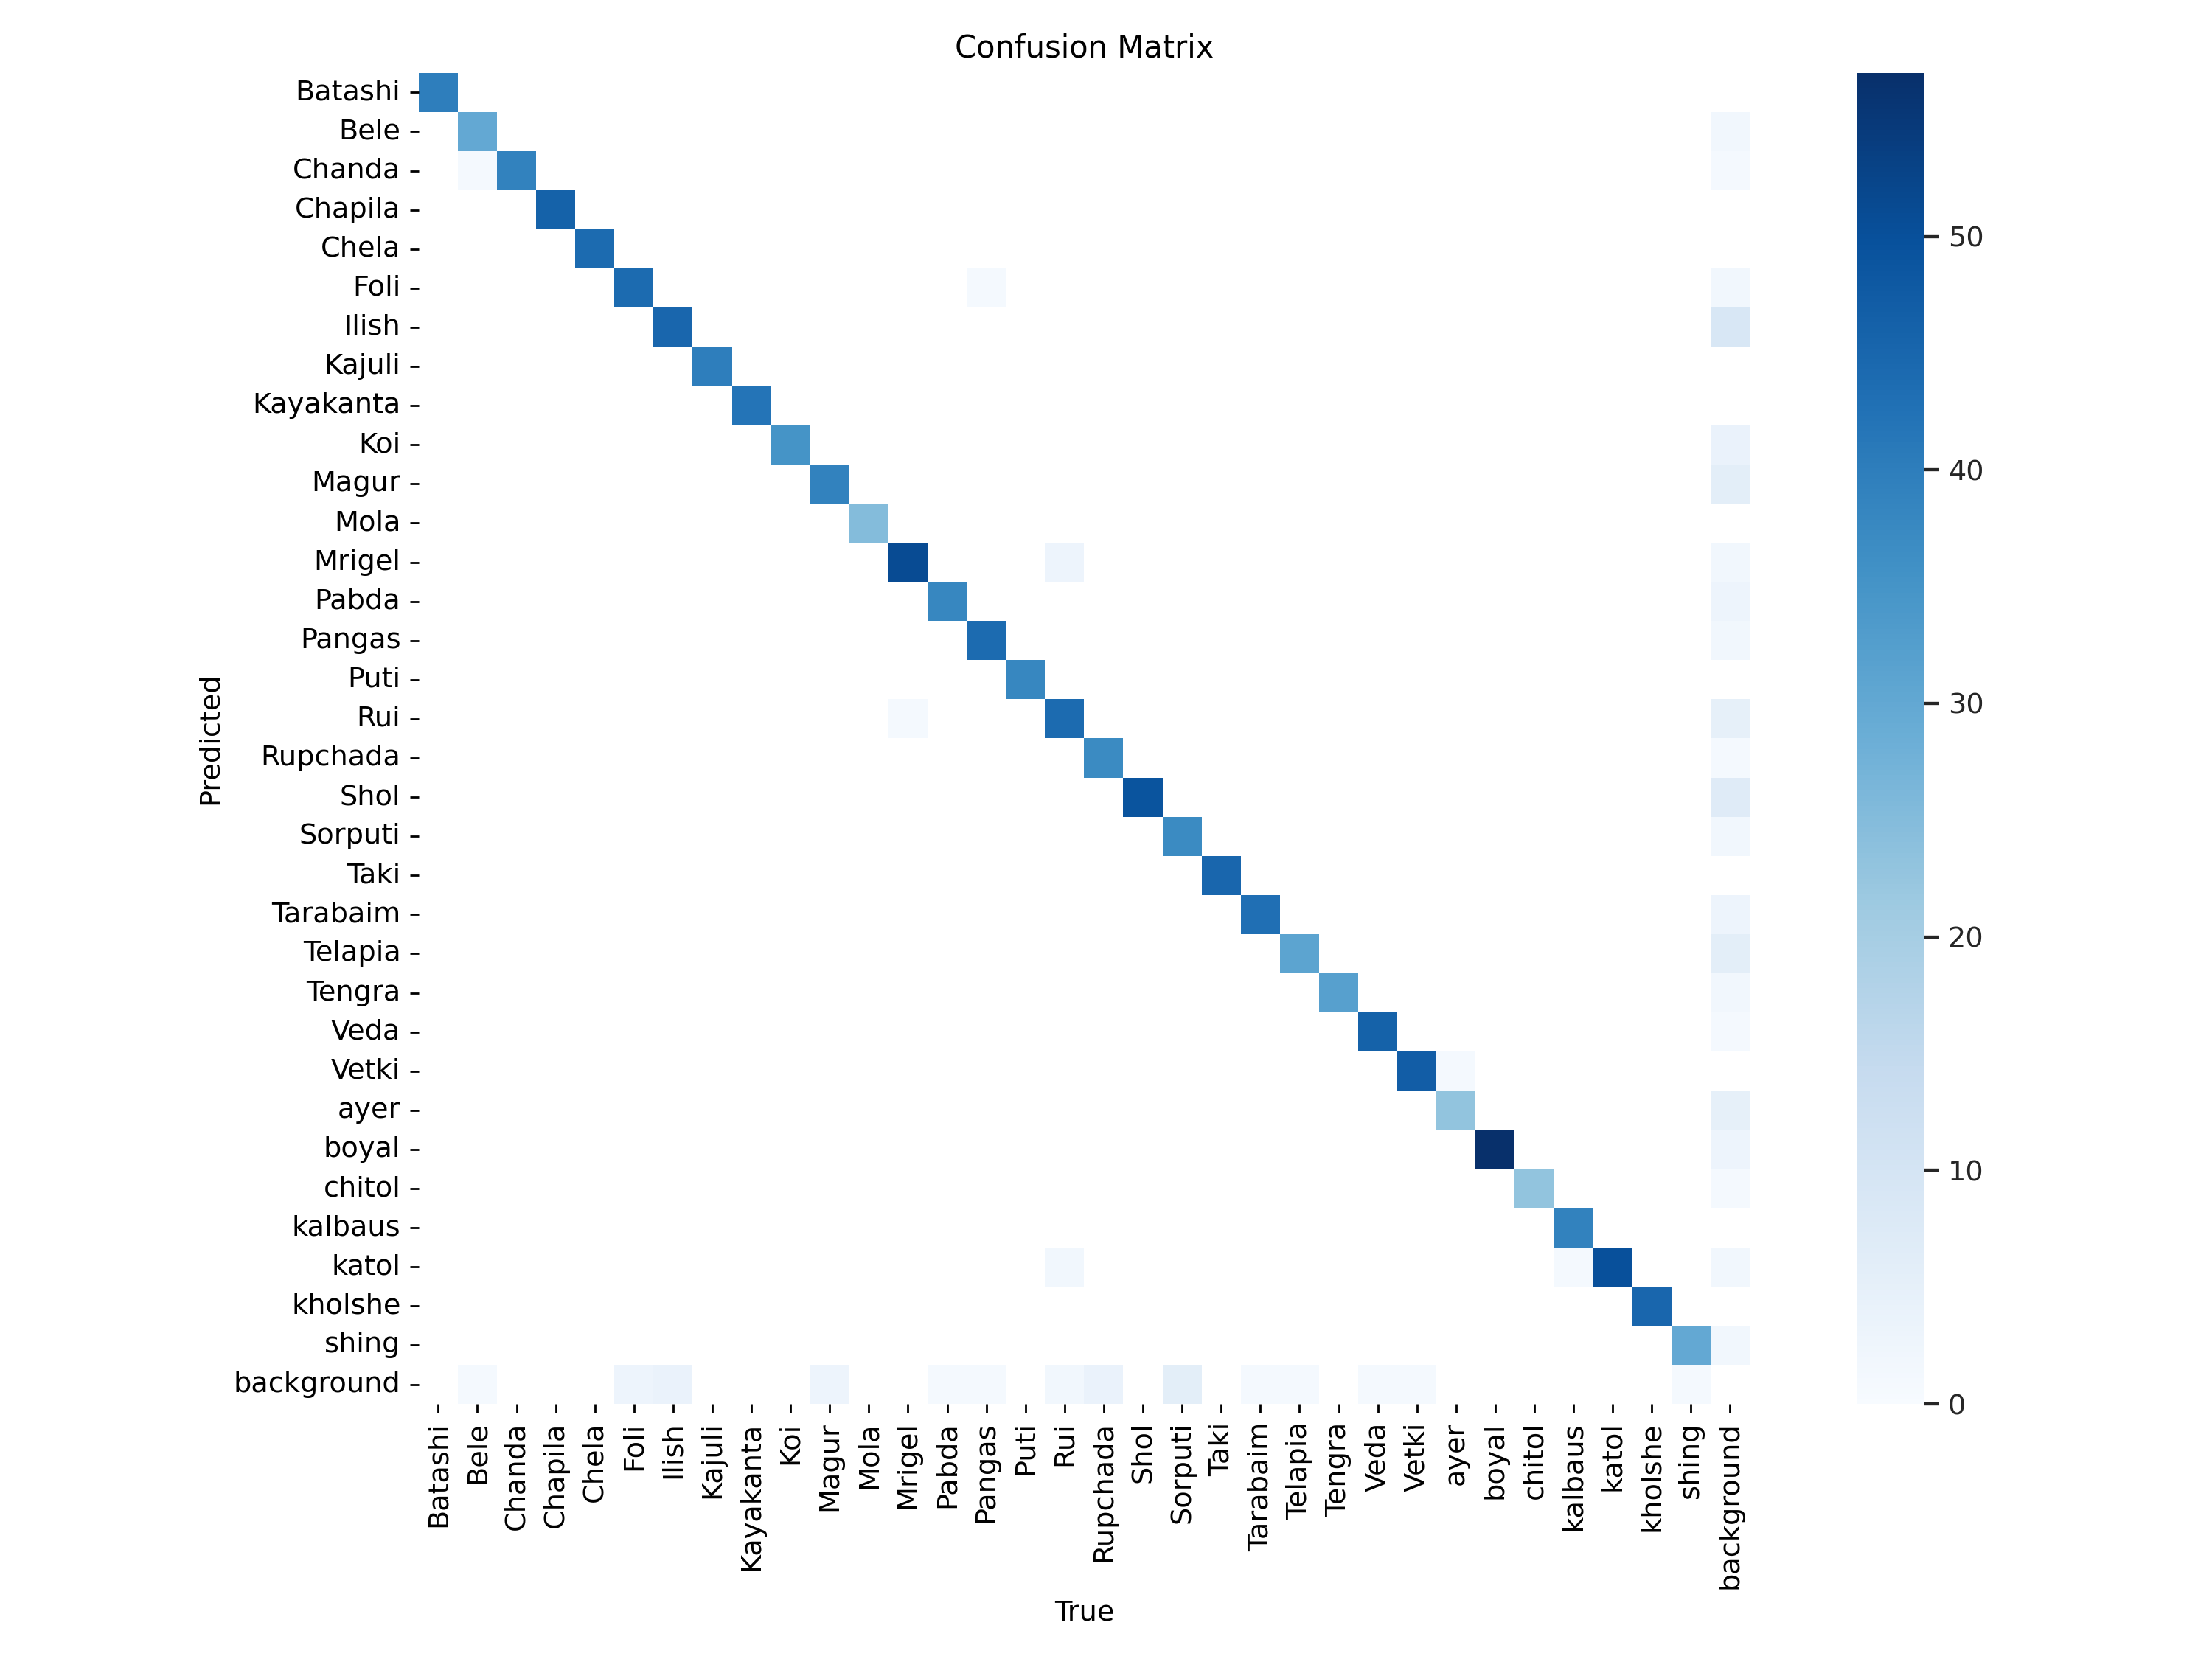

In [23]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/val/confusion_matrix.png', width=600)

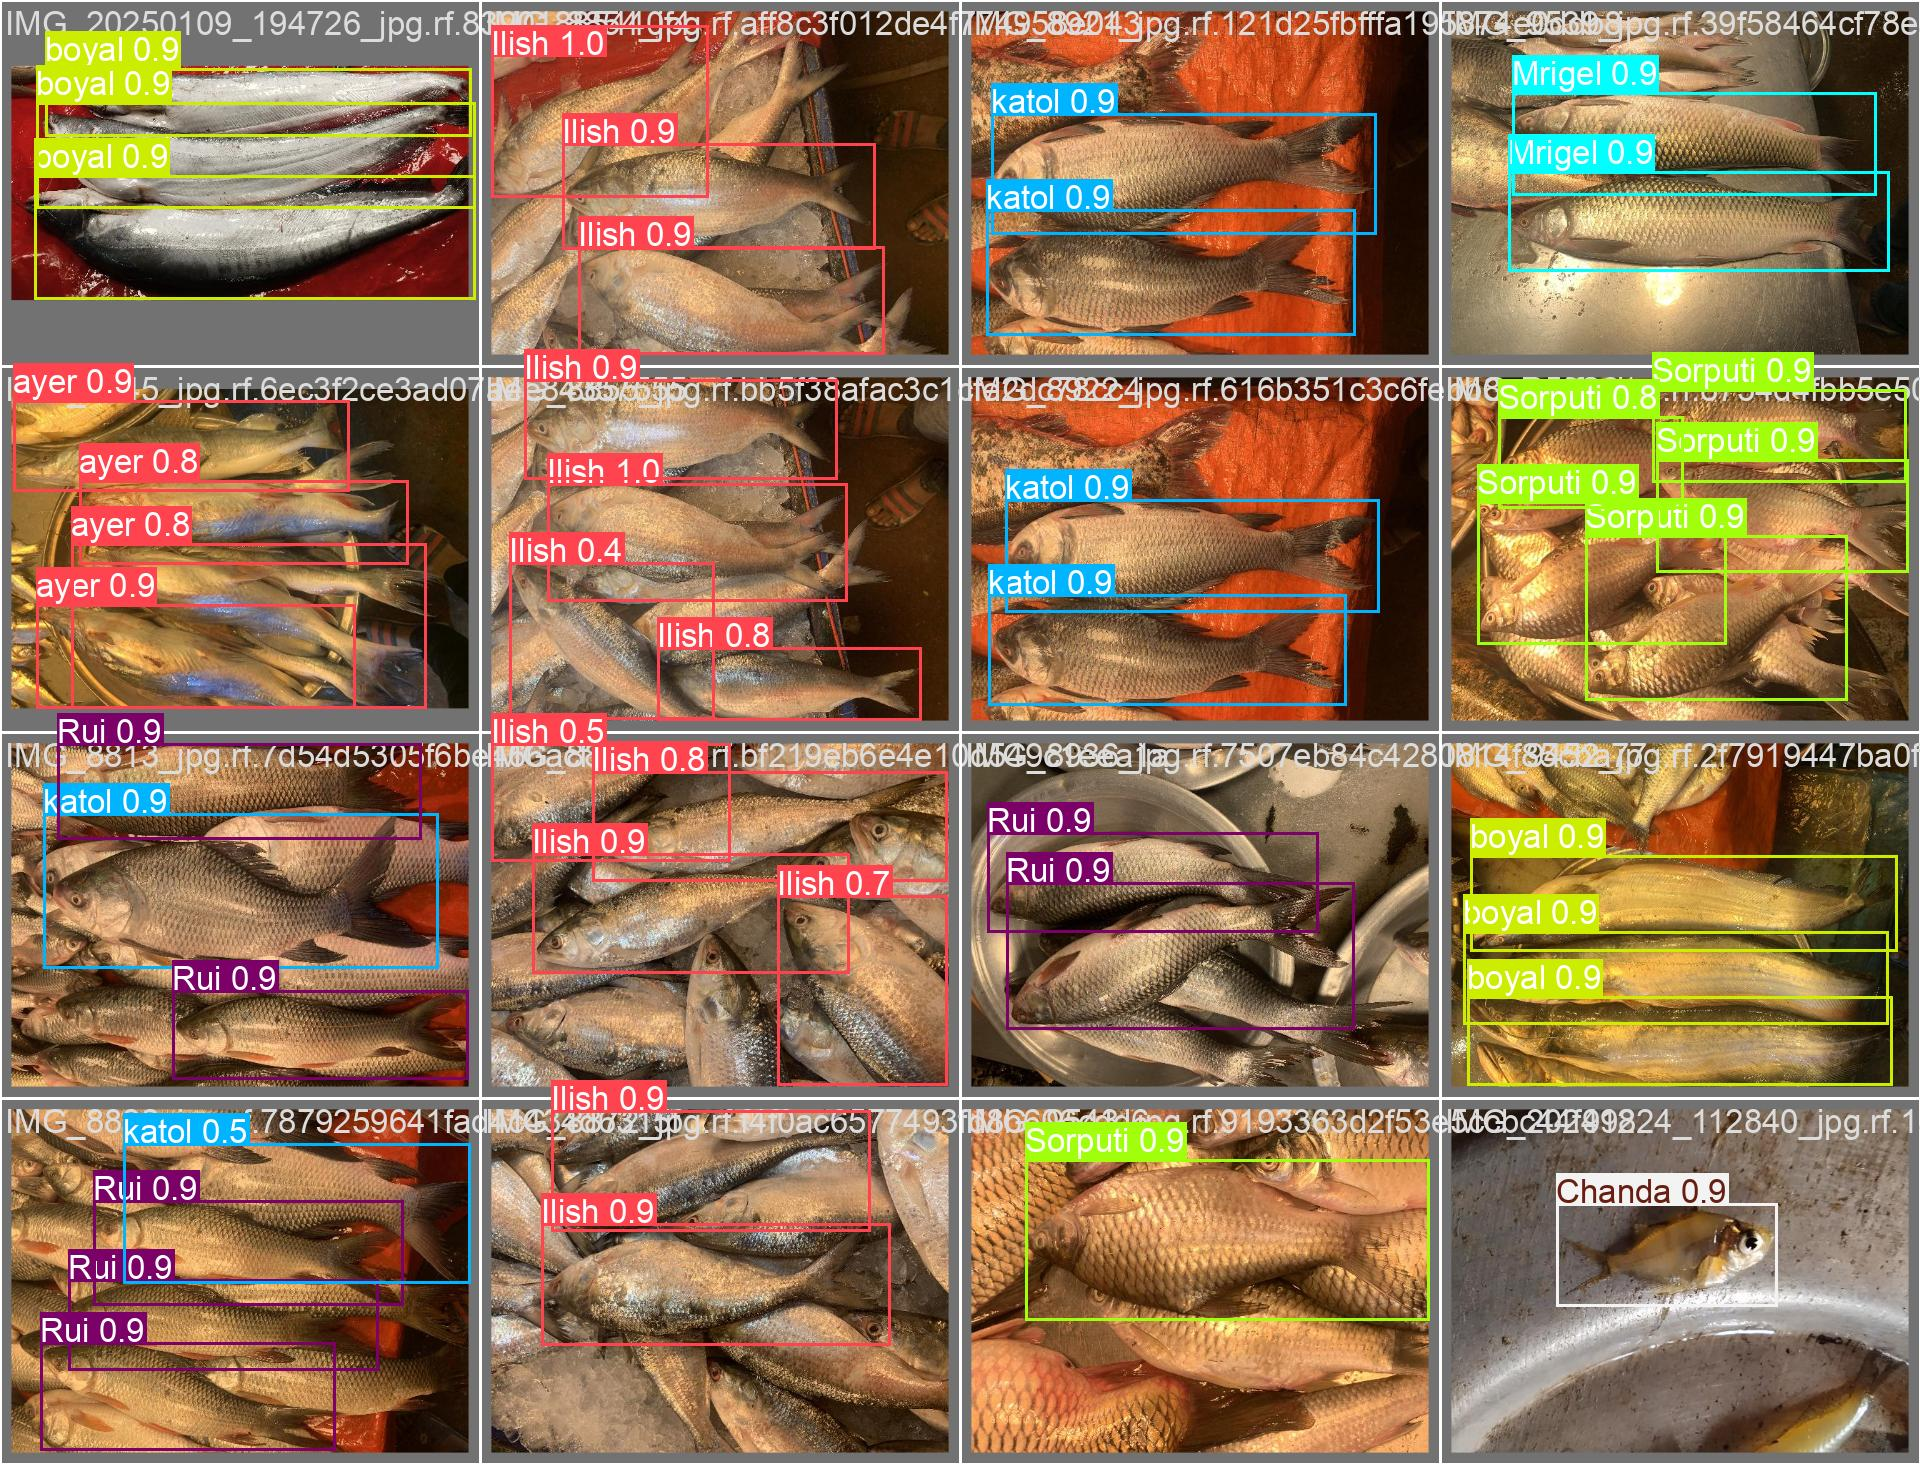

In [24]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/val/val_batch0_pred.jpg', width=600)

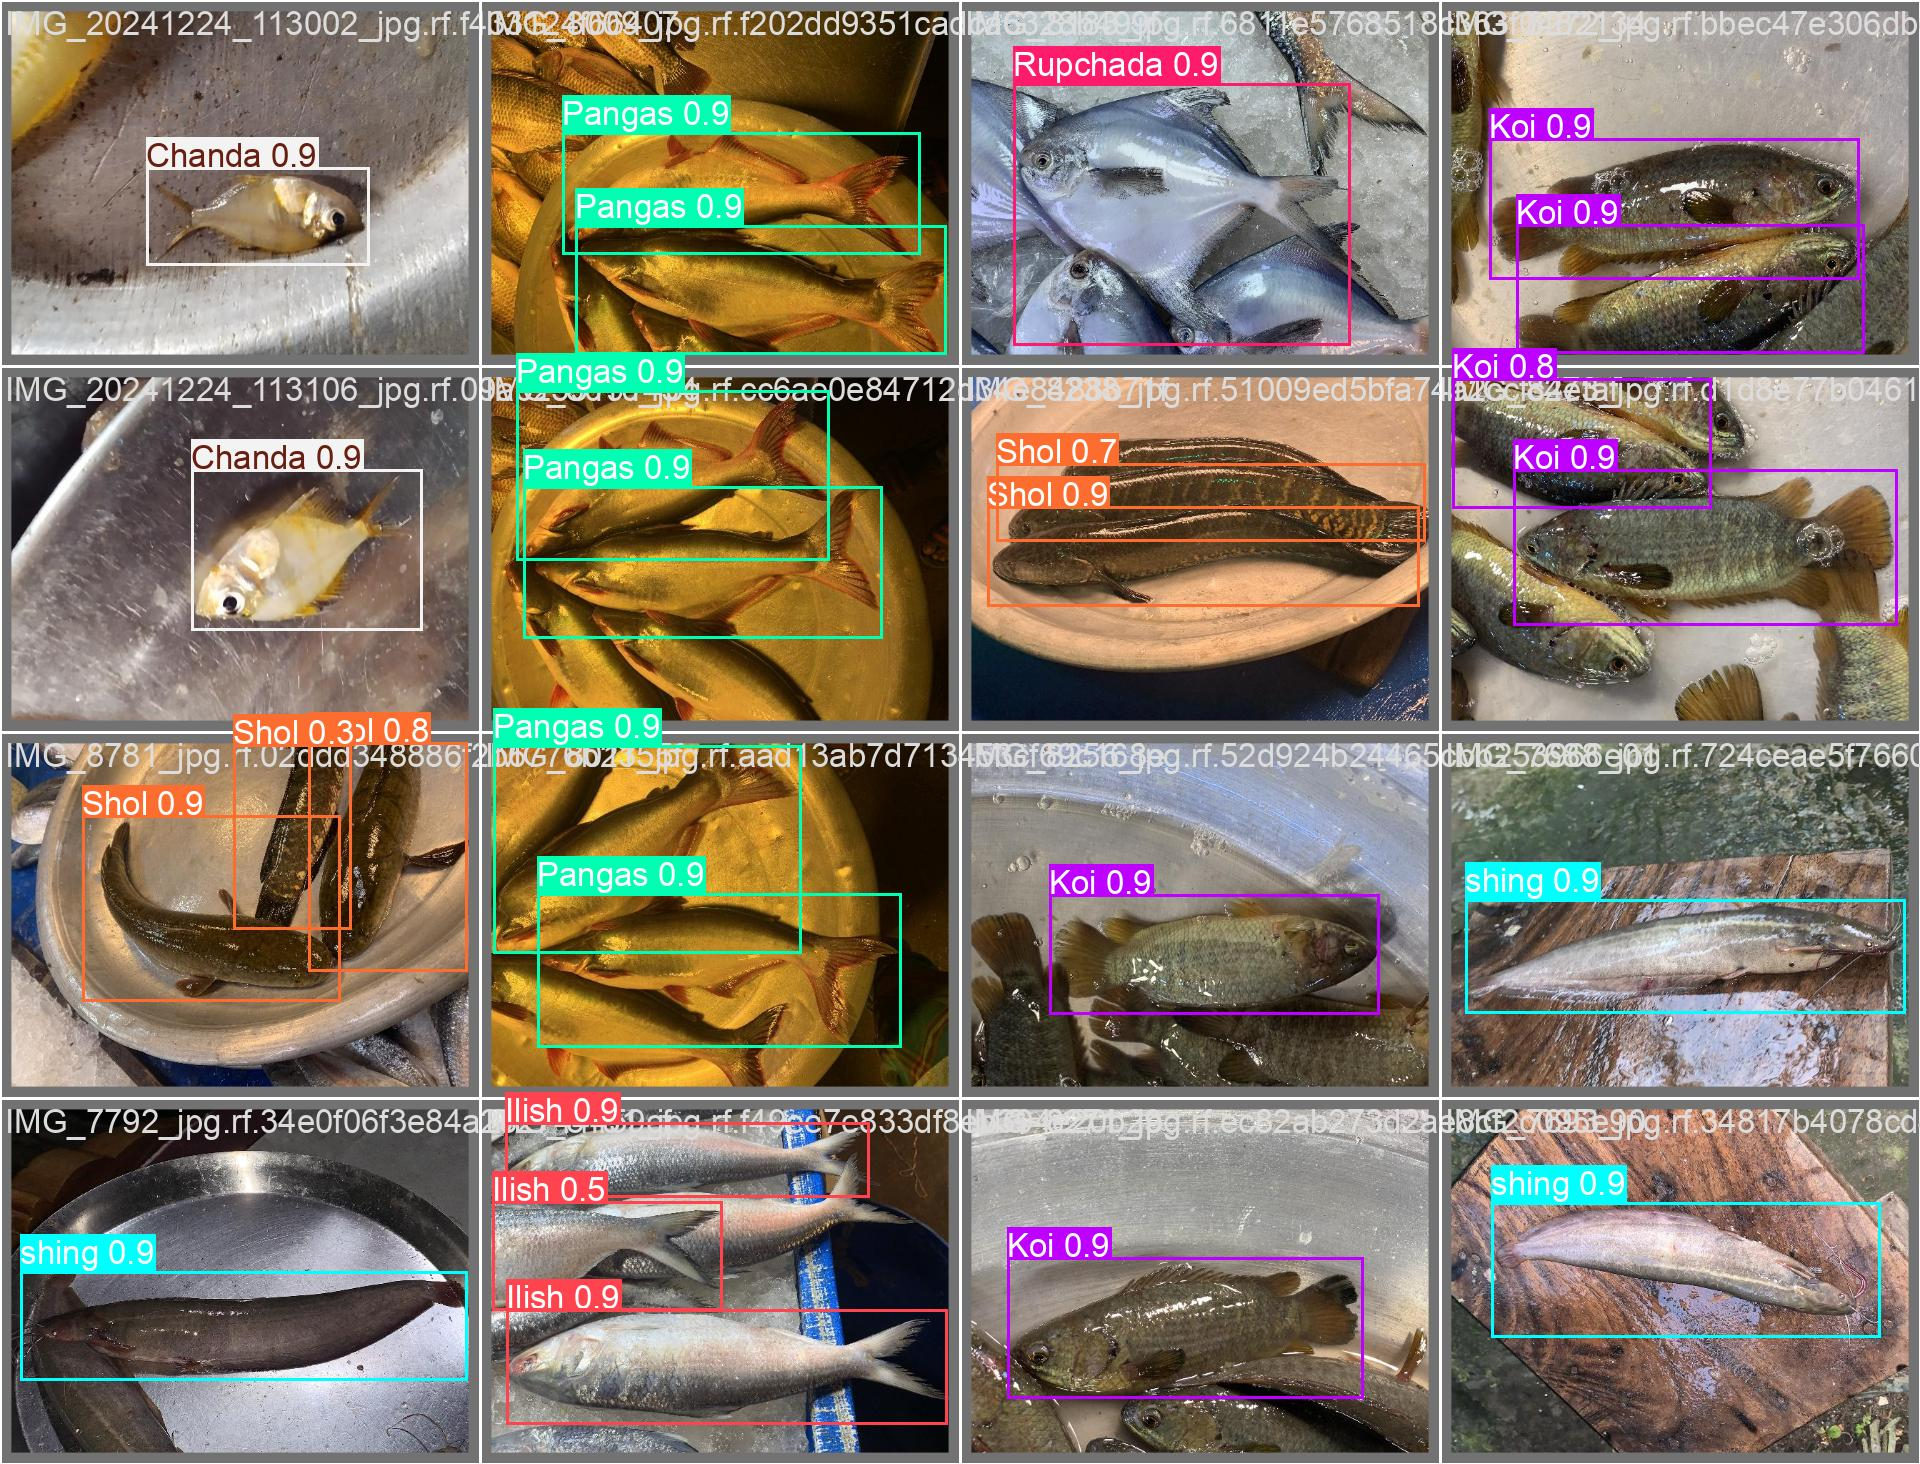

In [25]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/val/val_batch1_pred.jpg', width=600)

## Inference with custom model

In [12]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,425,571 parameters, 0 gradients, 21.4 GFLOPs

image 1/510 /content/datasets/-bd-delta-fish--4/test/images/IMG_0079_jpg.rf.1123de611ac72ba83c2c27cf4dd784ba.jpg: 640x480 1 chitol, 1 katol, 49.6ms
image 2/510 /content/datasets/-bd-delta-fish--4/test/images/IMG_0144_jpg.rf.ec2a8080692b6f844efbe03e2644cce4.jpg: 640x480 1 Vetki, 1 chitol, 12.2ms
image 3/510 /content/datasets/-bd-delta-fish--4/test/images/IMG_0152_jpg.rf.1c13aba59b84264426d309385b9ed0f2.jpg: 640x352 1 chitol, 44.9ms
image 4/510 /content/datasets/-bd-delta-fish--4/test/images/IMG_0155_jpg.rf.9d8f3b6cbeb13f5f1d8384a7ae3ca763.jpg: 640x384 1 chitol, 53.6ms
image 5/510 /content/datasets/-bd-delta-fish--4/test/images/IMG_20241207_131813_jpg.rf.ed7823ebef6cbc99f273921e3e3f44a0.jpg: 512x640 1 Mrigel, 1 Rui, 43.2ms
image 6/510 /content/datasets/-bd-delta-fish--4/test/images/IMG_20241208_155034_jpg.rf.02436e6e25c9754

**NOTE:** Let's take a look at few results.

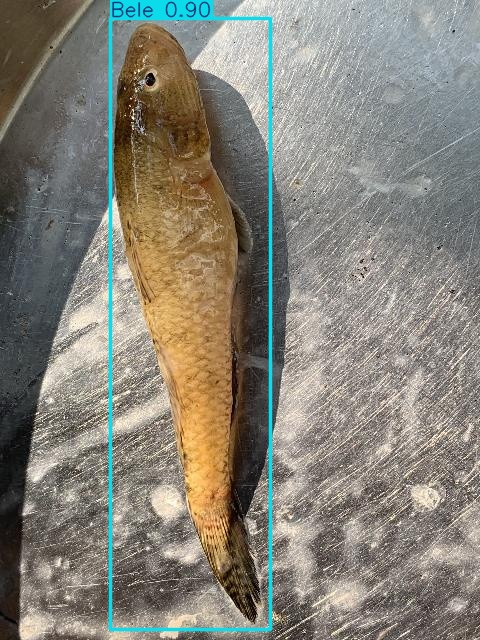

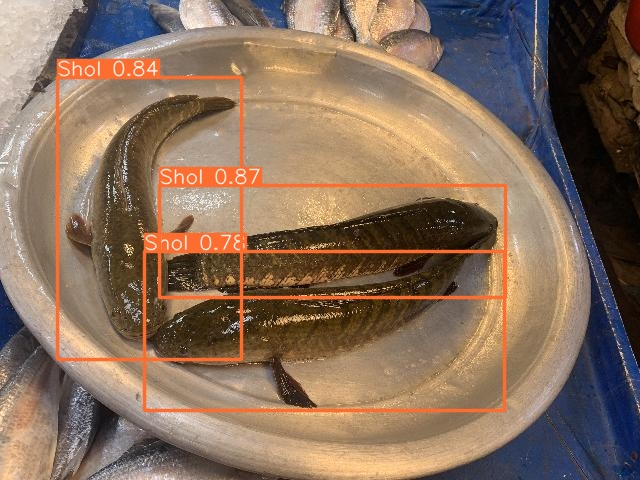

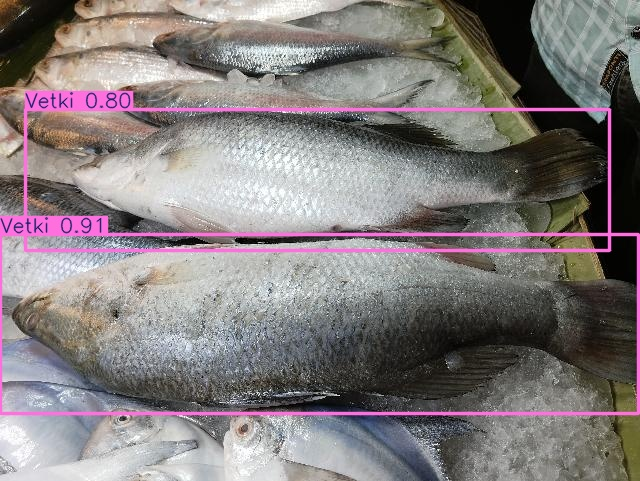

In [20]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[48:51]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [21]:
import shutil

shutil.make_archive("/content/runs/detect", "zip", "/content/runs/detect")


'/content/runs/detect.zip'